# Pneumonia detection based on Transfer learning and CNN

## Abstract
* This project proposes a convolutional neural network model to classify and detect the presence of pneumonia from a collection of chest X-ray image samples. 
* This model could help mitigate the reliability and interpretability challenges often faced when dealing with medical imagery. 
* It is difficult to obtain a large amount of pneumonia dataset for this classification task.
* Therefore, we deployed Structure Correcting Adversarial Network to segment lung fields relied on a pre-trained model to improve the validation and classification accuracy of the CNN model and achieved remarkable validation accuracy.

## Preprocessing
* Using dataset from stanford medical.
* Slice images with a `DataSegmentation`.
* Rotate images with a `DataAugmentation`.

## Model selection
* Fine tune the final layers of an existing deep neural network for a new classification task.
* add layers for feature selection and model fitting.

## Fitting dataset
* Load images with a `DataGeneration`.
* Fit dataset with model we selected.

* GPU:  Considering to use higher resolution images, we requires a GPU instance for doing this project.

## Create a Dataset

In [1]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt

from PIL import Image
from skimage import io
from keras import optimizers
from keras import applications
from keras.optimizers import Adam
from keras.models import Sequential,load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
K.clear_session()

In [3]:
nrow, ncol = 200,200
batch_size = 32
ntr = 1000
nts = 300

## Loading a Pre-Trained Deep Network

We load a pre-trained deep VGG19 network. 

In [4]:
input_shape = (nrow,ncol,3)
base_model = applications.VGG19(weights='imagenet',
                                include_top = False,
                                input_shape = input_shape)
model = Sequential()
for layer in base_model.layers:
    model.add(layer)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

Now, add the following layers to our new `model`:
* A `Flatten()` layer which reshapes the high dimension tensor into a single channel.
* A fully-connected layer with 64 output units and `relu` activation
* A `Dropout(0.1)` layer.
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [6]:
for layer in model.layers:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

## Data Augmentation
* In a lot of real-world use cases, even small-scale data collection can be extremely expensive or sometimes near-impossible, like medical images. 

* Being able to make the most out of very little data is a key skill of a competent data scientist.

* In our examples we will use two sets of pictures, which is very few examples to learn from, for a classification problem that is far from simple. So this is a challenging machine learning problem, but it is also a realistic one.

* In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [8]:
def Aug(path):
    path1 = "Pneumonia/"
    path2 = "non_Pneumonia/"

    ang1 = 7
#     if (not os.path.exists(path+'opt_dic/')):
#         os.mkdir(path+'opt_dic/')
#     if (not os.path.exists(path+'opt_dic/Pneumonia')):
#         os.mkdir(path+'opt_dic/Pneumonia')
#     if (not os.path.exists(path+'opt_dic/non_Pneumonia')):
#         os.mkdir(path+'opt_dic/non_Pneumonia')
    for filename in os.listdir(path+path1):              
        im = Image.open(path + path1 + filename[:-4] + '.jpg')
        im_rotate1 = im.rotate(360 - ang1)
        im_rotate2 = im.rotate(ang1)
        im_rotate1.save(path + path1 + filename[:-4] + '_l.jpg')
        im_rotate2.save(path + path1 + filename[:-4] + '_r.jpg')
    for filename in os.listdir(path + path2):              
        im = Image.open(path+path2 + filename[:-4]+'.jpg')
        im_rotate1 = im.rotate(360 - ang1)
        im_rotate2 = im.rotate(ang1)
        im_rotate1.save(path + path2 + filename[:-4] +'_l.jpg')
        im_rotate2.save(path + path2 + filename[:-4] +'_r.jpg')
    return 'Data Augmentation Done'

In [9]:
Aug('./train/')
Aug('./test/')

'Data Augmentation Done'

In [10]:
train_data_dir = './train'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (nrow,ncol),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size = (nrow,ncol),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary')

Found 50031 images belonging to 2 classes.
Found 12516 images belonging to 2 classes.


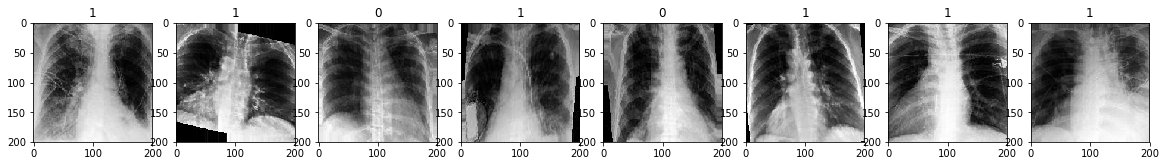

In [11]:
X,y = train_generator.next()
nplot = 8
plt.figure(figsize = (20,20))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    plt.title(int(y[i]))
    plt.imshow(X[i], cmap='gray')

## Grid Search and F1-score evaluation
* To determine the best hyper-parameter for our model, we have to use grid search to do the hyper-parameter optimization, we choose learning rate, decay and number of epochs as our hyper-parameters.

* We choose F1-score as our evaluation as the paper used in the ChexNet model.

In [12]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*(precision*recall)/(precision+recall+K.epsilon())

def GridSearch(lr,dc,ep):
    lr, decay, n_epochs = lr, dc, ep
    Matrix_acc, Matrix_valacc = np.zeros([3,3,3]), np.zeros([3,3,3])
    for i,lrt in enumerate(lr):
        for j,dcy in enumerate(decay):
            for k,npc in enumerate(n_epochs):
                print('learning rate = ',lrt,'Decay = ',dcy,'Num of epochs = ',npc)
                opt = optimizers.RMSprop(lr = lrt,decay = dcy)
                model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
                hist = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = npc,
                                           validation_data = test_generator, validation_steps = validation_steps)
                Matrix_acc[i,j,k] = np.mean(hist.history['acc'])
                Matrix_valacc[i,j,k] = np.mean(hist.history['val_acc'])
    print(Matrix_acc,'\n',Matrix_valacc)
    return np.argmax(Matrix_acc), np.argmax(Matrix_valacc) 

In [13]:
steps_per_epoch = ntr // batch_size
validation_steps = nts // batch_size
lr = [1e-3, 1e-4, 1e-5]
decay = [1e-3, 1e-4, 1e-5]
n_epochs = [5, 10, 15]
best_acc, best_valacc = GridSearch(lr,decay,n_epochs)

learning rate =  0.001 Decay =  0.001 Num of epochs =  5
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
31/31 [==============================] - 11s - loss: 3.3376 - acc: 0.7903 - val_loss: 3.4874 - val_acc: 0.7812
Epoch 2/5
31/31 [==============================] - 7s - loss: 3.3749 - acc: 0.7883 - val_loss: 3.5981 - val_acc: 0.7743
Epoch 3/5
31/31 [==============================] - 8s - loss: 3.7124 - acc: 0.7671 - val_loss: 3.2106 - val_acc: 0.7986
Epoch 4/5
31/31 [==============================] - 7s - loss: 3.7124 - acc: 0.7671 - val_loss: 4.3177 - val_acc: 0.7292
Epoch 5/5
31/31 [==============================] - 7s - loss: 3.5195 - acc: 0.7792 - val_loss: 3.8195 - val_acc: 0.7604
learning rate =  0.001 Decay =  0.001 Num of epochs =  10
Epoch 1/10
31/31 [==============================] - 9s - loss: 3.3267 - acc: 0.7913 - val_loss: 3.2660 - val_acc: 0.7951
Epoch 2/10
31/31 [==============================] - 7s - loss: 3.7767 - acc: 0.7631 - val_

In [15]:
print('we get highest acc with learning rate = ',lr[int(best_acc/9)],
      ',decay =',decay[int((best_acc%9)/3)],
      ', Num of epochs = ',n_epochs[best_acc%3])

we get highest acc with learning rate =  0.0001 ,decay = 0.001 , Num of epochs =  5


In [16]:
print('we get highest val_acc with learning rate = ',lr[int(best_valacc/9)],
      ',decay =',decay[int((best_valacc%9)%3)],
      ', Num of epochs = ',n_epochs[best_valacc%3])

we get highest val_acc with learning rate =  0.0001 ,decay = 0.001 , Num of epochs =  5


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
31/31 [==============================] - 10s - loss: 3.4553 - f1_score: 0.8768 - val_loss: 3.7642 - val_f1_score: 0.8645
Epoch 2/5
31/31 [==============================] - 7s - loss: 3.8249 - f1_score: 0.8617 - val_loss: 3.3767 - val_f1_score: 0.8798
Epoch 3/5
31/31 [==============================] - 7s - loss: 3.5517 - f1_score: 0.8723 - val_loss: 3.4874 - val_f1_score: 0.8757
Epoch 4/5
31/31 [==============================] - 7s - loss: 3.5035 - f1_score: 0.8751 - val_loss: 3.5981 - val_f1_score: 0.8704
Epoch 5/5
31/31 [==============================] - 7s - loss: 3.5356 - f1_score: 0.8742 - val_loss: 3.6790 - val_f1_score: 0.8672
Epoch 1/5
31/31 [==============================] - 9s - loss: 3.5035 - f1_score: 0.8741 - val_loss: 3.4320 - val_f1_score: 0.8779
Epoch 2/5
31/31 [==============================] - 7s - loss: 3.5195 - f1_score: 0.8729 - val_loss: 3.3767 - val_f1_score: 0.8801
Epoch 3/5
31/31 

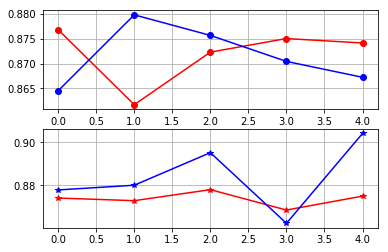

In [17]:
opt1 = optimizers.RMSprop(lr = lr[int(best_acc/9)],
                          decay = decay[(best_acc%9)%3])
model.compile(optimizer=opt1,
              loss='binary_crossentropy', 
              metrics=[f1_score])
hist1 = model.fit_generator(train_generator, 
                           steps_per_epoch = steps_per_epoch,
                           epochs = n_epochs[best_acc%3], 
                           validation_data = test_generator, 
                           validation_steps = validation_steps)

opt2 = optimizers.RMSprop(lr = lr[int(best_valacc/9)],
                          decay = decay[(best_valacc%9)%3])
model.compile(optimizer=opt2,
              loss='binary_crossentropy', 
              metrics=[f1_score])
hist2 = model.fit_generator(train_generator, 
                           steps_per_epoch = steps_per_epoch,
                           epochs = n_epochs[best_valacc%3], 
                           validation_data = test_generator, 
                           validation_steps = validation_steps)


plt.xlabel('Epoch')
plt.ylabel('F1_score')
plt.legend(['Train', 'Test'])
print('We can check the F1_score of models above')
plt.subplot(2,1,1)
plt.plot(hist1.history['f1_score'], 'ro-')
plt.plot(hist1.history['val_f1_score'], 'bo-')
plt.grid()
plt.subplot(2,1,2)
plt.plot(hist2.history['f1_score'], 'r*-')
plt.plot(hist2.history['val_f1_score'], 'b*-')
plt.grid()